### Creating Custom & Built-in Tools For RAG Agent

In [1]:
#importing libraries
import os
from dotenv import load_dotenv

load_dotenv()

from langchain_groq import ChatGroq

from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain.tools import tool

from langchain.agents import create_agent

from typing_extensions import TypedDict
from typing import Annotated, List
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


model = ChatGroq(model="llama-3.1-8b-instant")
embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")


d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#custom relevant document retriever function


documents = DirectoryLoader(path=".", glob='**/*.txt', loader_cls=TextLoader, loader_kwargs={"encoding":"utf-8"}).load()
chunks = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100).split_documents(documents)
vectorstore = FAISS.from_documents(documents=chunks, embedding=embeddings)
retriever = vectorstore.as_retriever()

@tool        
def relevant_docs_func(query:str):
    'this function is used to fetch relevant documents for given query and combine them together'
    relevant_docs = retriever.invoke(query)
    combined_docs = "\n\n".join(doc.page_content for doc in relevant_docs)

    return combined_docs


In [3]:
#built-in tools - wikipedia, arxiv

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max =500))

arxiv = ArxivQueryRun(api_wrapper=ArxivAPIWrapper(top_k_results=3, doc_content_chars_max=500))



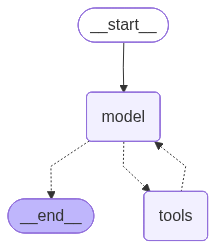

In [4]:
#creating agent with bind tools

tools = [relevant_docs_func, wikipedia, arxiv]
agent = create_agent(
    model=model,
    tools=tools
)

agent

In [5]:
#defining state schema

class RAGState(TypedDict):
    messages: Annotated[List, add_messages]

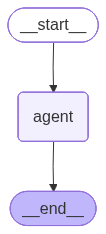

In [6]:
#workflow of graph

graph = StateGraph(RAGState)

graph.add_node("agent", agent)

graph.add_edge(START, "agent")
graph.add_edge("agent", END)

graph_builder = graph.compile()
graph_builder

In [11]:
#invocation

user_query="what were the usecases of langchain given in notes"

response = graph_builder.invoke({"messages":user_query})
response

KeyboardInterrupt: 